# Visão Computacional com Aprendizado Profundo

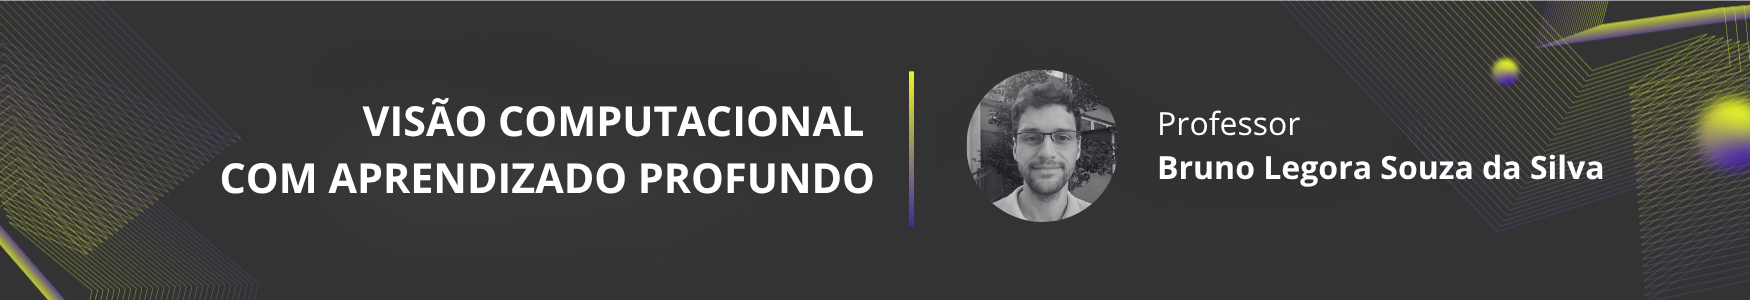

# Laboratório 7 - Segmentação Semântica com U-net

Neste laboratório, vamos conhecer a arquitetura U-net e usá-la para a tarefa de Segmentação Semântica.


### Segmentação Semântica

A tarefa de segmentação semântica é uma das tarefas de visão computacional relacionadas a imagens. Enquanto a classificação de imagens retorna uma classe para cada imagem - por exemplo, se ela é uma face de uma pessoa, ou se a imagem é de um prédio - a segmentação semântica é uma tarefa em que cada pixel deve ser classificado como pertencente a um objeto de determinado tipo, como pássaro, cachorro, fundo, etc.

Neste caso, enquanto na tarefa de classificação de imagens, a saída era um número (ou um vetor de números) indicando as classes, a saída de redes feitas para a tarefa de segmentação de imagens são outras imagens, cujos valores dos pixels representam as classes.

Abaixo seguem dois exemplos de imagens com as suas respectivas segmentação semântica. Nela, os pixels na cor amarela são marcados como pertencentes a um pássado, e os roxos a um cachorro.



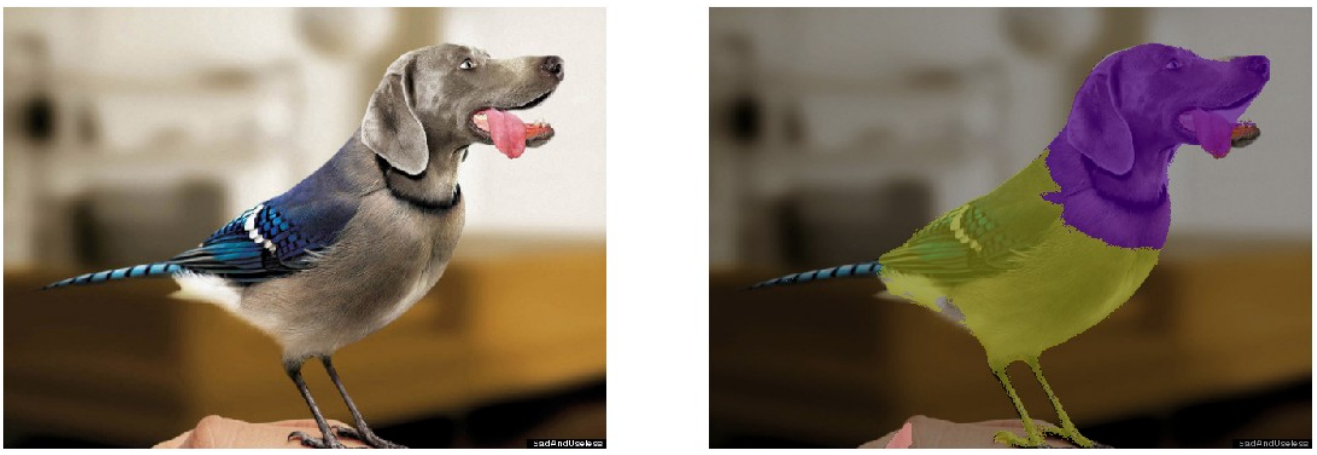

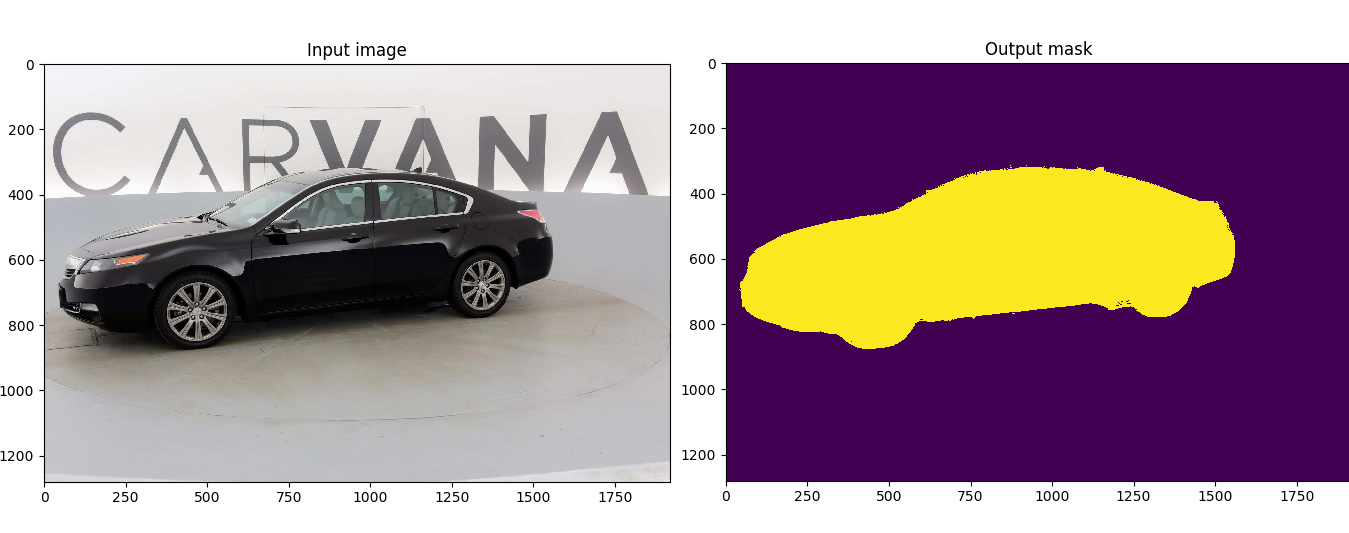

Para que redes possam classificar imagens, precisamos inserir camadas totalmente conectadas ao final dels. Todas as redes apresentadas na Aula 07 possuem essa característica.

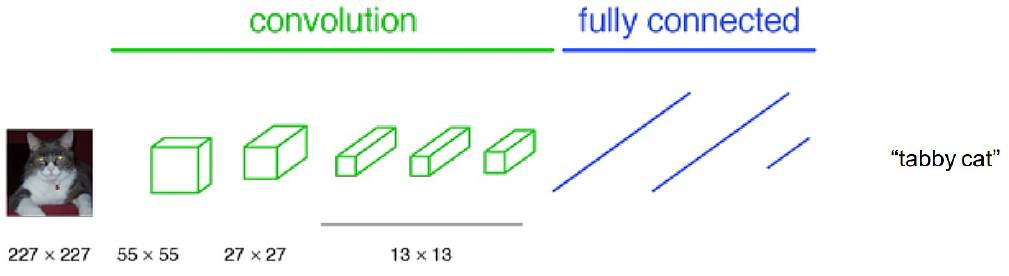

Para que as saídas de nossas redes sejam imagens, não podemos colocar essas camadas totalmente conectadas. Então, usamos apenas camadas convolucionais e de pooling.

### FCN

Desta forma, as redes que lidam com esse problema geralmente são chamadas de Fully Convolutional Networks (FCN). Essas redes foram usadas em 2014 [neste artigo](https://arxiv.org/abs/1411.4038).

Em cada camada convolucional, a resolução da imagem tende a cair devido à operação de convolução, strides e pooling. Para manter a resolução de uma imagem em uma arquitetura convolucional, devemos fazer um padding do tipo "same" e não alterarmos os strides e nem usarmos max-pooling. Porém, essas operações são importantes na construção de redes convolucionais.

Desta forma, ao usar camadas convolucionais, perdemos resolução, o que não é interessante para a tarefa de segmentação semântica. Podemos construir uma rede com camadas projetadas para, por exemplo, reduzir a dimensão pela metade e em seguida usarmos um algoritmo de upsampling comum para dobrar a resolução. Neste caso, um pixel de saída da rede levaria informação de pelo menos 4 pixels da imagem de saída (para dobrar a resolução, 1 pixel se torna 2 na altura e 2 na largura), o que não é o ideal.

Ainda no trabalho da FCN, citado acima, foi proposta a operação de "deconvolução" (também chamada de convolução transposta ou de up-conv), que nada mais é que uma operação de convolução com stride fracional (entre 0 e 1).
Em termos de implementação, basta inverter os passos da camada de convolução que temos uma camada de deconvolução.

Intuitivamente, é como se "expandíssemos" a imagem original 3x3 (azul), fizessemos a convolução dela, gerando uma imagem (verde) maior. Stride 1 quer dizer que a janela "pula" uma vez para ser centralizada no vizinho à direita. Já um stride menor que um (por exemplo, 1/2), quer dizer que precisamos mover o filtro de convolução duas vezes para centralizar ele no próximo pixel, como mostra a imagem abaixo.


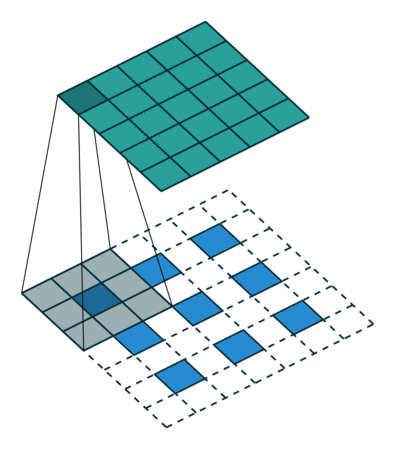

Assim, combinando operações de convolução (que diminuem o tamanho da imagem), e de deconvolução (que aumentam o tamanho da imagem), uma FCN pode ser construída. A arquitetura da primeira FCN proposta no trabalho citado anteriormente é mostrada abaixo:




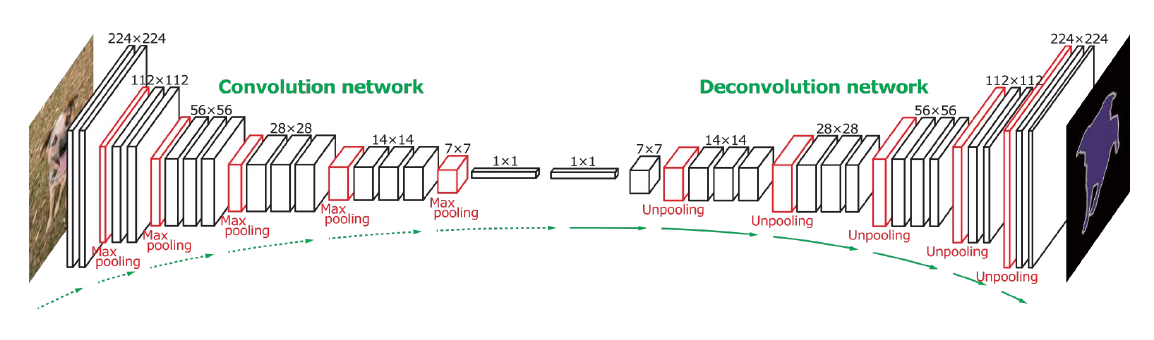

Essa arquitetura foi usada na tarefa de segmentação semântica. Assim como na tarefa de classificação, logo em seguida surgiu uma outra arquitetura com características melhores que ela.

### U-net

Em 2015, pesquisadores propuseram a arquitetura U-net [neste artigo](https://arxiv.org/abs/1505.04597). A diferença dela está no formato "em U" que suas camadas são posicionadas, como mostra a imagem abaixo.

Ela é quase uma FCN, porém com conexões similares as conexões residuais das ResNet (embora estas conexões são chamadas de copy and crop nesta rede)

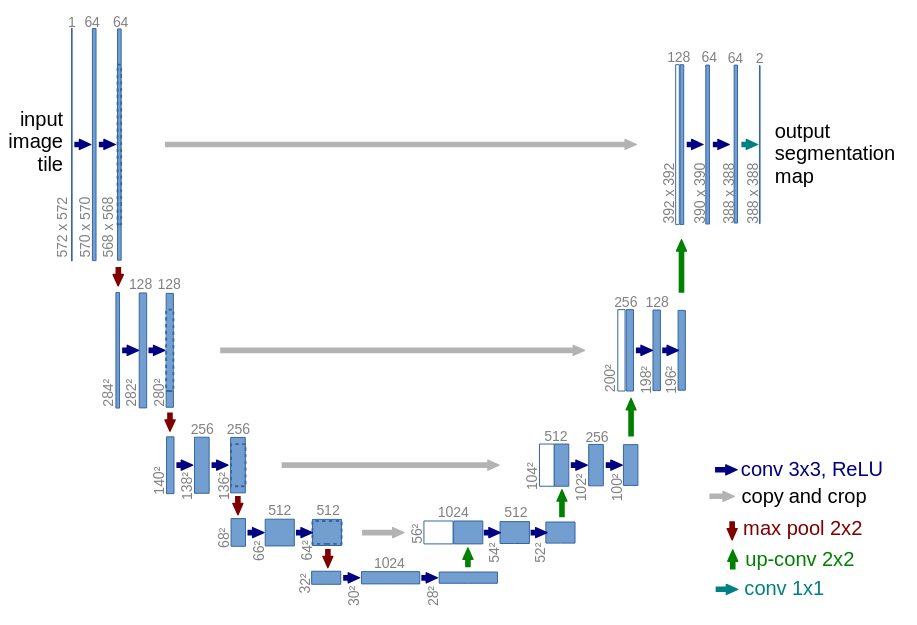

Nesta arquitetura, podemos definir dois tipos de blocos.

O primeiro tipo, chamados de Encoders, são compostos de duas camadas convolucionais com ativação ReLU, seguidas de um pooling. À esquerda da imagem, temos quatro blocos deste tipo.

Já o segundo bloco, chamado de Decoder, é composto de uma camada de up-conv (deconvolução ou convolução transposta), uma concatenação entre as conexões residuais e a saída dessa primeira convolução, seguido de duas convoluções com ativação ReLU.

Na "base" do U, temos duas camadas convolucionais com 1024 filtros, enquanto na saída da rede temos uma convolução 1x1.

Combinando esses módulos, e definindo o número de canais da saída para o número de diferentes classes, a rede chamada U-net é construída. Iremos montá-la logo abaixo neste laboratório.

Essa arquitetura, como foi proposta, possui 23 camadas convolucionais e cerca de 30 milhões de parâmetros!

Vamos então construir essa rede e treiná-la em uma base de dados de segmentação semântica!

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import torch
import torchvision

# Neste laboratório, veremos outra forma de definir redes neurais usando Pytorch
# É possível construir usando apenas a forma Sequential, mas o código ficaria longo

# Como temos muitas repetições de blocos iguais, iremos estender a classe torch.nn.Module,
# criando nosso próprio módulo (subrede)!

# O código abaixo cria um módulo básico de nome "BlocoEncoder" com dois parâmetros configuráveis
# no construtor (método __init__(...)) - num_canais_entrada e num_canais_saida;

# Variáveis locais são criadas e o método "forward" é definido descrevendo como que uma entrada
# x percorre pela rede até ela saida - basicamente passando por todas as camadas.

class BlocoEncoder(torch.nn.Module):

    def __init__(self, num_canais_entrada, num_canais_saida, padding='valid'):
        super().__init__()
        self.layer1 = torch.nn.Conv2d(num_canais_entrada, num_canais_saida, kernel_size=3, padding=padding)
        self.layer2 = torch.nn.ReLU(inplace=True)
        self.layer3 = torch.nn.Conv2d(num_canais_saida, num_canais_saida, kernel_size=3, padding=padding)
        self.layer4 = torch.nn.ReLU(inplace=True)
        self.layer5 = torch.nn.MaxPool2d(2)

    def forward(self, x):
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)
      x = self.layer5(x)
      return x

# Da mesma forma, o BlocoDecoder é criado. Mas aqui há algumas diferenças, principalmente no método forward.
# O __init__ também define as camadas, mas o método forward é responsável por concatenar a saída da camada de
# convolução transposta com a skip_connection que ela recebe. Reparem que a skip connection é um parâmetro do
# método forward!
# A saída do upscale é concatenado com a skip connection. Porém, a operação de "copy and crop" deve ser feita para
# que os tamanhos sejam os mesmos. Para isso, usaremos o método torchvision.transforms.Resize para
# redimensionar a skip_connection de forma que ela tenha o mesmo tamanho da saída do upscale (x.size())

# Reparem na imagem acima que o resultado da concatenação da saída do bloco de upconv com a skip_connection
# possui o mesmo número de canais do bloco imediatamente anterior. Isso significa que o upconv diminui a
# quantidade de canais pela metade, e esse tensor com metade dos canais (N/2) é concatenado com um tensor de mesmo
# tamanho para que os N canais sejam mantidos na saída da operação da skip connection.
# Ex: O bloco superior à direita possui 128 canais na entrada, e a upconv possui 64 canais. Esses 64 canais
# são concatenados com os 64 canais da skip connection, formando os 128 canais "do inicio do bloco".

class BlocoDecoder(torch.nn.Module):

    def __init__(self, num_canais_entrada, num_canais_saida, padding='valid'):
        super().__init__()
        # upconv diminui o numero de canais pela metade!
        self.up = torch.nn.ConvTranspose2d(num_canais_entrada, num_canais_entrada // 2, kernel_size=2, stride=2)
        self.layer1 = torch.nn.Conv2d(num_canais_entrada, num_canais_saida, kernel_size=3, padding=padding)
        self.layer2 = torch.nn.ReLU(inplace=True)
        self.layer3 = torch.nn.Conv2d(num_canais_saida, num_canais_saida, kernel_size=3, padding=padding)
        self.layer4 = torch.nn.ReLU(inplace=True)

    def forward(self, x, skip_connection):
      x = self.up(x)
      skip_connection = torchvision.transforms.Resize((x.size()[2],x.size()[3]))(skip_connection)
      x = torch.cat([skip_connection, x], dim=1)
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)
      return x

# Obs: Poderíamos construir os módulos da seguinte forma
# num_canais_entrada_bloco1 = 1
# num_canais_saida_bloco1 = 64
# encoder1 = torch.nn.Sequential(
#     torch.nn.Conv2d(num_canais_entrada_bloco1, num_canais_saida_bloco1, kernel_size=3, padding='valid'),
#     torch.nn.ReLU(inplace=True),
#     torch.nn.Conv2d(num_canais_saida_bloco1, num_canais_saida_bloco1, kernel_size=3, padding='valid')
#     torch.nn.ReLU(inplace=True),
#     torch.nn.MaxPool2d(2)
# )
# num_canais_entrada_bloco2 = 64
# num_canais_saida_bloco2 = 128
# encoder1 = torch.nn.Sequential(
#     torch.nn.Conv2d(num_canais_entrada_bloco2, num_canais_saida_bloco2, kernel_size=3, padding='valid'),
#     torch.nn.ReLU(inplace=True),
#     torch.nn.Conv2d(num_canais_saida_bloco2, num_canais_saida_bloco2, kernel_size=3, padding='valid')
#     torch.nn.ReLU(inplace=True),
#     torch.nn.MaxPool2d(2)
# )

# E assim sucessivamente... Ou ainda construirmos a U-net diretamente. Mas daí ficam duas questões:
# Muito código copiado!!!
# Como faríamos as skip connections?



Definidos os dois tipos de blocos, podemos começar a construir nossa rede neural U-Net, do jeito que ela foi projetada!



In [ ]:
class UNet(torch.nn.Module):
    def __init__(self, n_channels, n_classes, padding='valid'):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.encoder1 = BlocoEncoder(n_channels,64,padding=padding)
        self.encoder2 = BlocoEncoder(64,128,padding=padding)
        self.encoder3 = BlocoEncoder(128,256,padding=padding)
        self.encoder4 = BlocoEncoder(256,512,padding=padding)
        self.base1 = torch.nn.Conv2d(512, 1024, kernel_size=3, padding=padding)
        self.relu1 = torch.nn.ReLU(inplace=True)
        self.base2 = torch.nn.Conv2d(1024, 1024, kernel_size=3, padding=padding)
        self.relu2 =  torch.nn.ReLU(inplace=True)
        self.decoder1 = BlocoDecoder(1024,512,padding=padding)
        self.decoder2 = BlocoDecoder(512,256,padding=padding)
        self.decoder3 = BlocoDecoder(256,128,padding=padding)
        self.decoder4 = BlocoDecoder(128,64,padding=padding)
        self.conv1 = torch.nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.encoder4(x3)
        x = self.base1(x4)
        x = self.relu1(x)
        x = self.base2(x)
        x = self.relu2(x)
        x = self.decoder1(x,x4) # skip connection aqui!
        x = self.decoder2(x,x3) # skip connection aqui!
        x = self.decoder3(x,x2) # skip connection aqui!
        x = self.decoder4(x,x1) # skip connection aqui!
        x = self.conv1(x)
        return x

# Podemos criar uma U-Net com 3 canais de entrada e 2 classes da seguinte forma:
unet = UNet(3,2)

Neste ponto, uma observação deve ser feita.

A tarefa de segmentação semântica requer que a iamgem de saída seja do mesmo tamanho da imagem de entrada. Na U-net que montamos, isso não ocorre (pela imagem, a entrada tem tamanho 572x572 e a saída 388x388). O motivo disso é que todas as camadas convolucionais não fazem padding. Assim, cada convolução reduz a dimensão da imagem em um determinado valor.

Ao configurarmos nossa rede para que todas as camadas de convolução trabalhem com padding do tipo "same" (tamanho da entrada = tamanho da saída), é possível fazer com que a saída tenha o mesmo tamanho da entrada.

No caso, a imagem 572x572 resulta numa saída 560x560. Isso ocorre pois temos 4 blocos que diminuem a resolução pela metade:

1º bloco -> 572 para 286
2º bloco -> 286 para 143
3º bloco -> 143 para 71 (divisão inteira!)
4º bloco -> 71 para 35 (divisão inteira!)

E na "volta", essa resolução é aumentada também em 4x:

1º bloco decoder -> 35 para 70
2º bloco decoder -> 70 para 140
3º bloco decoder -> 140 para 280
4º bloco decoder -> 280 para 560

Neste caso, se a rede diminui a resolução de uma imagem em 16x, como é o caso da U-net, a resolução original deve ser múltipla de 16 para que a saída seja do mesmo tamanho, devido ao processo de divisão inteira.

Vamos então treinar e testar a U-net nas células abaixo!

In [ ]:
# Carregando o dataset:

import os
working_dir = "."

pets_path_train = os.path.join(working_dir, 'OxfordPets', 'train')
pets_path_test = os.path.join(working_dir, 'OxfordPets', 'test')
pets_train_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_train, split="trainval", target_types="segmentation", download=True)
pets_test_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_test, split="test", target_types="segmentation", download=True)



100%|██████████| 792M/792M [00:29<00:00, 26.9MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 12.0MB/s]
100%|██████████| 792M/792M [00:51<00:00, 15.3MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 10.6MB/s]


Após baixar, temos 3680 imagens de treino/validação e 3669 de teste!

In [ ]:
pets_train_orig, pets_test_orig


(Dataset OxfordIIITPet
     Number of datapoints: 3680
     Root location: ./OxfordPets/train,
 Dataset OxfordIIITPet
     Number of datapoints: 3669
     Root location: ./OxfordPets/test)

Vamos ver um par de imagens de exemplo. Começando pela entrada:

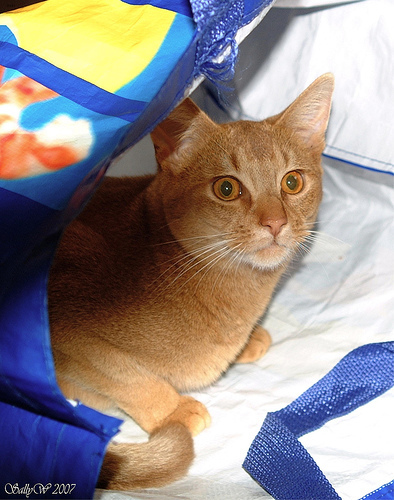

In [ ]:
(train_pets_input, train_pets_target) = pets_train_orig[0]
train_pets_input

E a saída, que possui 3 diferentes níveis:

- Valor 1 - Região onde está o animal
- Valor 2 - Região onde NÃO está o animal
- Valor 3 - Região de borda (ambígua)

Para mostrá-la, vamos fazer uma normalização antes:

(500, 394)


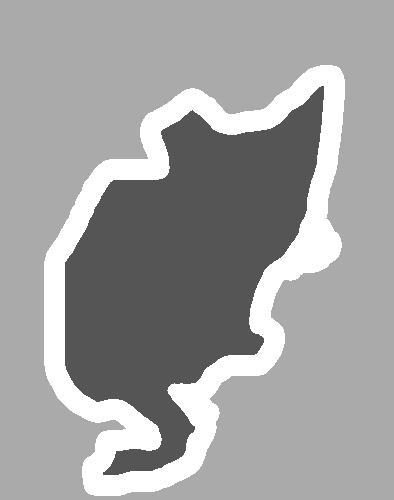

In [ ]:
target = np.asarray(train_pets_target)
target = target*255.0/np.max(target)

print(target.shape)
cv2_imshow(target)

A base de dados, neste caso, é grande para carregarmos toda de uma vez. Se usarmos cerca de 50% da base, usamos quase toda a memória do Colab. Vamos usar cerca de 10% da base (~368 imagens)


In [ ]:
def arredondaMultiplo16(num):
  return (num // 16) * 16;

def pilToResizedTensor(x):
  new_sz1 = arredondaMultiplo16(x.size[0])
  new_sz2 = arredondaMultiplo16(x.size[1])
  new_sz = (new_sz1,new_sz2)
  return torchvision.transforms.functional.pil_to_tensor(x.resize(new_sz)).float()

def transformTargets(x):
  target = pilToResizedTensor(x)
  # A saída da rede neural possui 3 classes (3 matrizes indicadoras de cada class)
  # enquanto nosso target possui 1 canal só com valores de 0 a 2.
  # Convertendo abaixo:
  target = torch.cat([ (target == i) for i in range(1,4) ], dim=0).float()
  target = target
  return target

percentage = 10

pets_train_Tensor = []
target_train_Tensor = []
pets_test_Tensor = []
target_test_Tensor = []

for i in range(len(pets_train_orig)//(100//percentage)):
  pets_train_Tensor.append(pilToResizedTensor(pets_train_orig[i][0]))
  target_train_Tensor.append(transformTargets(pets_train_orig[i][1]))


for i in range(len(pets_test_orig)//(100//percentage)):
  pets_test_Tensor.append(pilToResizedTensor(pets_test_orig[i][0]))
  target_test_Tensor.append(transformTargets(pets_test_orig[i][1]))

# num_batches = 1

# pets_train_loader = torch.utils.data.DataLoader(pets_train_orig,
#                                                 batch_size=3680//num_batches,
#                                                 shuffle=True)

# pets_test_loader = torch.utils.data.DataLoader(pets_test_orig,
#                                                 batch_size=3669//num_batches,
#                                                 shuffle=True)

Vamos treinar a U-net!

Neste caso, temos uma situação não muito ideal. Cada uma das imagens da base de dados possui um tamanho diferente. As características em comum são que elas contém um animal de estimação e que elas são RGB.

Como a arquitetura U-net suporta imagens de tamanhos distintos (desde que múltiplas de 16, como comentado acima), isso teoricamente não é um problema, pois conseguiremos treiná-la.

A questão é que não é possível construir um tensor único com todas as imagens para que possamos mandar para o treinamento da rede neural de uma só vez. E isso torna o treinamento um pouco mais demorado.

Devido a restrição do tamanho múltiplo de 16, precisamos redimensionar as imagens em alguns casos.

Assim, dentro de cada época da base de dados, devemos fazer um laço em que passamos uma imagem por vez para a rede (poderíamos juntar imagens de tamanhos iguais também).

Ao final, calculamos a média dos erros de cada imagem de treinametno.

Spoiler: Isso é MUITO RUIM para o treinamento de uma rede neural, pois traz muita instabilidade no treinamento.

Obs: Como estamos usando um pedaço da base de dados devido a questão da memória, não vamos esperar bons resultados. Além disso, por questões de tempo, vamos fazer poucas iterações (como o processo é feito imagem por imagem, é mais demorado, como falado acima).

Em aulas futuras, vamos aprender como "resolver" esse problema da memória!

Vamos ao treinamento:

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Criando a rede neural:

unet = UNet(3,3,'same') # 3 canais de entrada, 1 canal de saída e padding "same"
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=0.001)

num_epochs = 20
loss_fn = torch.nn.CrossEntropyLoss()

# Loop das épocas
for n in range(num_epochs):
  total_loss = 0
  # Loop das imagens
  for m in range(len(pets_train_Tensor)):
    (inputs, outputs) = (pets_train_Tensor[m],target_train_Tensor[m])
    # Reshapes abaixo apenas para converter de um tensor 3-D de tamanho (X,Y,Z)
    # para um tensor 4-D (1,X,Y,Z)
    inputs = inputs.reshape((1,inputs.size()[0],inputs.size()[1],inputs.size()[2])).to(device)
    outputs = outputs.reshape((1,outputs.size()[0],outputs.size()[1],outputs.size()[2])).to(device)

    # Passo "forward" da rede
    pred_targets = unet(inputs)

    # Calcula a função de perda
    loss = loss_fn(pred_targets, outputs)

    # Otimiza
    optimizer.zero_grad()
    loss.backward()
    # Soma a loss dessa imagem
    total_loss = total_loss + loss
    optimizer.step()
  # Calcula e imprime a média das loss
  total_loss = total_loss / len(pets_train_Tensor)
  print(f'Epoch: {n:03d}, Train loss: {float(loss):.6f}')




Epoch: 000, Train loss: 0.954425
Epoch: 001, Train loss: 0.918780
Epoch: 002, Train loss: 0.946108
Epoch: 003, Train loss: 0.893451
Epoch: 004, Train loss: 1.000272
Epoch: 005, Train loss: 0.998261
Epoch: 006, Train loss: 1.022069
Epoch: 007, Train loss: 1.027718
Epoch: 008, Train loss: 1.031518
Epoch: 009, Train loss: 1.033175
Epoch: 010, Train loss: 1.033806
Epoch: 011, Train loss: 1.034034
Epoch: 012, Train loss: 1.034116
Epoch: 013, Train loss: 1.034147
Epoch: 014, Train loss: 1.034161
Epoch: 015, Train loss: 1.034168
Epoch: 016, Train loss: 1.034172
Epoch: 017, Train loss: 1.034175
Epoch: 018, Train loss: 1.034176
Epoch: 019, Train loss: 1.034178


Vamos ver como está a saída dessa rede neural!

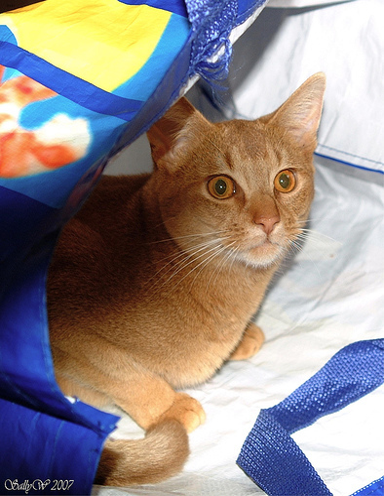

In [ ]:
def torch_2_cv(x):
  x = x.numpy()
  x = np.transpose(x,(1,2,0))
  return x


img_1 = pets_train_Tensor[0]
target_1 = target_train_Tensor[0]

img_1_cv = torch_2_cv(img_1)
img_1_cv = cv2.cvtColor(img_1_cv,cv2.COLOR_BGR2RGB)

cv2_imshow(img_1_cv)







---


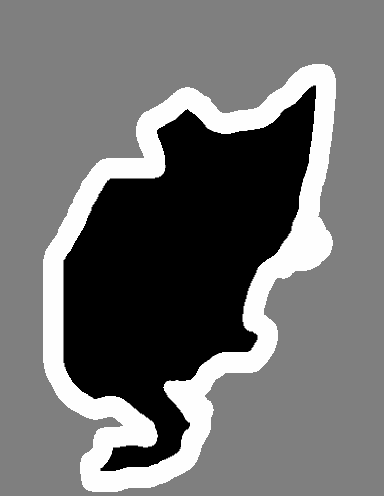

In [ ]:
target_1 = torch.argmax(target_1,dim=0).cpu().detach()
target_1 = target_1.numpy()*(255//2)

print("---")
cv2_imshow(target_1)

---


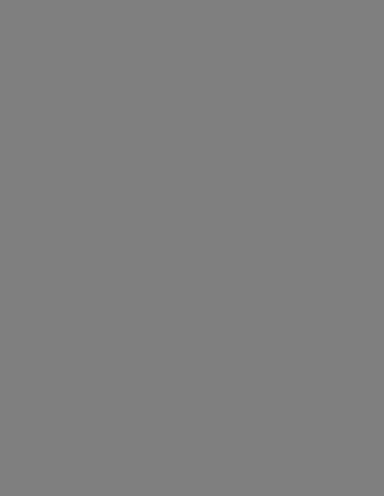

In [ ]:
img_1_net = img_1.reshape((1,img_1.size()[0],img_1.size()[1],img_1.size()[2])).to(device)
pred_1 = unet(img_1_net.to(device))
pred_1 = torch.argmax(pred_1,dim=1).cpu().detach()

pred_1 = torch_2_cv(pred_1)*(255//2)

print("---")
cv2_imshow(pred_1)


O resultado aparentemente não foi bom pelos motivos levantados acima. A saída da rede neural diz que tudo é fundo (resumindo: a maior parte dos pixels são "fundo", então se a rede neural chuta que todos são "fundo", ela obtém um resultado razoável).

Reparem que há bastante oscilação no treinamento da rede. Como falamos, essa estratégia de passar imagem por imagem para a rede causa instabilidade no treinaemnto da rede neural.

Mas pelo menos conseguimos treinar a rede neural...

Agora, façam o EA4, disponível no AVA da disciplina.

Na próxima semana iremos ver como melhorar esse treinamento!